In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
from scipy.stats import norm
import statistics

In [2]:
files = os.listdir()
csv_files = [file for file in files if file.endswith(".csv")]

In [3]:
combined_data = pd.DataFrame()

for csv_file in csv_files:
    file_path = os.path.join(csv_file)
    df = pd.read_csv(file_path)
    if csv_file == "Suntec_City.csv":
        df["occupancy_diff"] = df["carparkOccupancy"].diff().abs()
        sorted_df = df.sort_values(by="occupancy_diff", ascending=False)
        top_3_highest_diff = sorted_df.head(3)
        start_diff_index = top_3_highest_diff.index[0]
        end_diff_index = top_3_highest_diff.index[1]

        # Subtract the diff value from the row with the maximum diff onwards
        highest_diff = top_3_highest_diff["occupancy_diff"].max()
        df.loc[
            start_diff_index : end_diff_index - 1, "carparkOccupancy"
        ] -= highest_diff

        diff_after = (
            df["carparkOccupancy"].iloc[end_diff_index]
            - df["carparkOccupancy"].iloc[end_diff_index - 1]
        )

        df.loc[end_diff_index:, "carparkOccupancy"] -= diff_after

    combined_data = pd.concat([combined_data, df])

    combined_data["timestamp"] = pd.to_datetime(
        combined_data["timestamp"], dayfirst=True
    )
    combined_data["time"] = combined_data["timestamp"].dt.strftime("%H:%M")

    grouped_data = combined_data.groupby("name")

In [47]:
avg_df = pd.DataFrame()
i = 1

for _, data in grouped_data:
    avg_df["carparkOccupancy" + str(i)] = data["carparkOccupancy"]
    i += 1
avg_df["mean"] = avg_df.mean(axis=1).astype(int)
avg_df["time"] = list(range(24 * 60))

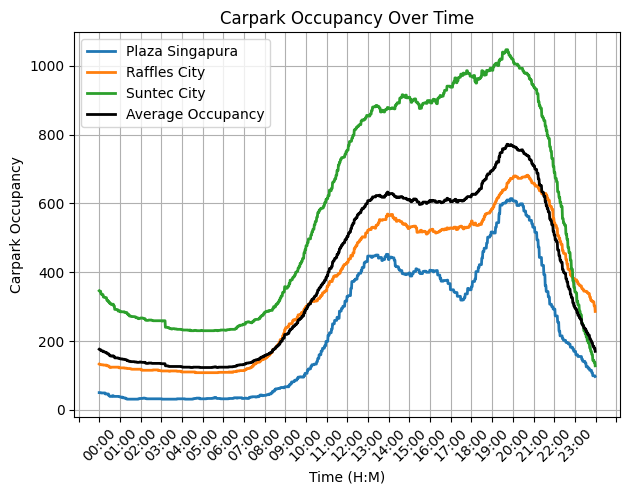

In [48]:
for group, data in grouped_data:
    plt.plot(
        data["time"],
        data["carparkOccupancy"],
        "-",
        lw=2,
        label=f"{group}",
    )

plt.plot(
    data["time"],
    avg_df["mean"],
    "-",
    lw=2,
    label="Average Occupancy",
    color="black",
)

ax = plt.gca()
loc = plticker.MultipleLocator(base=60.0)
ax.xaxis.set_major_locator(loc)

plt.xlabel("Time (H:M)")
plt.ylabel("Carpark Occupancy")
plt.title("Carpark Occupancy Over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Find the distribution on avg car occupancy


<Axes: ylabel='Density'>

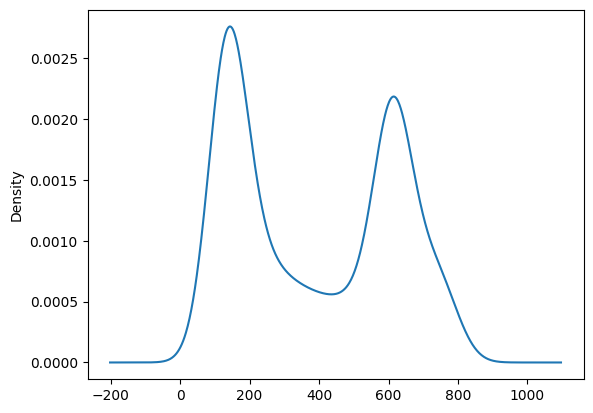

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

avg_df.to_csv('out.csv',index=False)

# Your dataset
data = avg_df["mean"]
data.plot(kind="kde")
